## Overview
> 1. Download the Communities and Crime data1
from https://archive.ics.uci.edu/ml/datasets/Communities+and+Crime. Use the frst 1495 rows of data asthe training set and the rest as the test set.  
2. The data set has missing values. Use a data imputation technique to deal with the missing values in the data set. The data description mentions some features are nonpredictive. Ignore those features.  
3. Plot a correlation matrix for the features in the data set.   
4.  Calculate the Coefficient of Variation CV for each feature, where CV = s/m, in which s is sample variance and m is sample mean..  
5.  Pick 128 features with highest CV , and make scatter plots and box plots for them.
6.  Fit a linear model using least squares to the training set and report the test error.    
7.  Fit a ridge regression model on the training set, with \$\lambda\$  chosen by cross-validation. Report the test error obtained.  
8.  Fit a LASSO model on the training set, with \$\lambda\$ chosen by cross-validation. Report the test error obtained, along with a list of the variables selected by the model. Repeat with standardized features. Report the test error for both cases and compare them.
9.  Fit a PCR model on the training set, with M (the number of principal components) chosen by cross-validation. Report the test error obtained.  
10. In this section, we would like to fit a boosting tree to the data. As in classification trees, one can use any type of regression at each node to build a multivariate regression tree. Because the number of variables is large in this problem, one can use L1-penalized regression at each node. Such a tree is called L1 penalized gradient boosting tree. 

## Data Cleaning and Data Preparation

In [23]:
# import  libaries
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.metrics import make_scorer, r2_score, mean_squared_error, auc, mean_absolute_error
from sklearn.model_selection import GridSearchCV, KFold
from matplotlib import style
style.use("ggplot")
import seaborn as sns

%matplotlib inline

In [24]:
# read data
df = pd.read_csv('./data/communities.txt',header=None,names=["col_" + str(i) for i in range(127)] + ['goal'])
# set train size 
train_size = 1495
df

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,...,col_118,col_119,col_120,col_121,col_122,col_123,col_124,col_125,col_126,goal
0,8,?,?,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,...,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
1,53,?,?,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,...,0.02,0.12,0.45,?,?,?,?,0.00,?,0.67
2,24,?,?,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,...,0.01,0.21,0.02,?,?,?,?,0.00,?,0.43
3,34,5,81440,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,...,0.02,0.39,0.28,?,?,?,?,0.00,?,0.12
4,42,95,6096,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,...,0.04,0.09,0.02,?,?,?,?,0.00,?,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1988,12,?,?,TempleTerracecity,10,0.01,0.40,0.10,0.87,0.12,...,0.01,0.28,0.05,?,?,?,?,0.00,?,0.09
1989,6,?,?,Seasidecity,10,0.05,0.96,0.46,0.28,0.83,...,0.02,0.37,0.20,?,?,?,?,0.00,?,0.45
1990,9,9,80070,Waterburytown,10,0.16,0.37,0.25,0.69,0.04,...,0.08,0.32,0.18,0.08,0.06,0.78,0,0.91,0.28,0.23
1991,25,17,72600,Walthamcity,10,0.08,0.51,0.06,0.87,0.22,...,0.03,0.38,0.33,0.02,0.02,0.79,0,0.22,0.18,0.19


In [25]:
# print df base info
df.describe()

,col_0,col_4,col_5,col_6,col_7,col_8,col_9,col_10,col_11,col_12,...,col_96,col_97,col_98,col_99,col_100,col_118,col_119,col_120,col_125,goal
count,1993.000000,1993.000000,1993.000000,1993.000000,1993.000000,1993.000000,1993.000000,1993.000000,1993.000000,1993.000000,...,1993.000000,1993.000000,1993.000000,1993.000000,1993.000000,1993.000000,1993.000000,1993.000000,1993.000000,1993.000000
mean,28.679378,5.491721,0.057622,0.463422,0.179408,0.753838,0.153748,0.144089,0.424240,0.493919,...,0.215660,0.608726,0.535018,0.626347,0.651440,0.065253,0.232920,0.161766,0.094099,0.237837
std,16.400609,2.872641,0.126931,0.163753,0.253313,0.244040,0.208908,0.232531,0.155232,0.143581,...,0.231142,0.204245,0.181392,0.200542,0.198231,0.109482,0.203121,0.229084,0.240379,0.232958
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,12.000000,3.000000,0.010000,0.350000,0.020000,0.630000,0.040000,0.010000,0.340000,0.410000,...,0.060000,0.470000,0.420000,0.520000,0.560000,0.020000,0.100000,0.020000,0.000000,0.070000
50%,34.000000,5.000000,0.020000,0.440000,0.060000,0.850000,0.070000,0.040000,0.400000,0.480000,...,0.130000,0.630000,0.540000,0.670000,0.700000,0.040000,0.170000,0.070000,0.000000,0.150000
75%,42.000000,8.000000,0.050000,0.540000,0.230000,0.940000,0.170000,0.160000,0.470000,0.540000,...,0.280000,0.770000,0.660000,0.770000,0.790000,0.070000,0.280000,0.190000,0.000000,0.330000
max,56.000000,10.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Pre-process

In [26]:
# Convert ? to NaN
# define function
def getNaN(x):
    if str(x) == '?':return np.nan
    else :return x 
    
# Convert ? to NaN
for i in df.columns:
    df[i] = df[i].apply(getNaN)
df

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,...,col_118,col_119,col_120,col_121,col_122,col_123,col_124,col_125,col_126,goal
0,8,NaN,NaN,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,...,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
1,53,NaN,NaN,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,...,0.02,0.12,0.45,NaN,NaN,NaN,NaN,0.00,NaN,0.67
2,24,NaN,NaN,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,...,0.01,0.21,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.43
3,34,5,81440,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,...,0.02,0.39,0.28,NaN,NaN,NaN,NaN,0.00,NaN,0.12
4,42,95,6096,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,...,0.04,0.09,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1988,12,NaN,NaN,TempleTerracecity,10,0.01,0.40,0.10,0.87,0.12,...,0.01,0.28,0.05,NaN,NaN,NaN,NaN,0.00,NaN,0.09
1989,6,NaN,NaN,Seasidecity,10,0.05,0.96,0.46,0.28,0.83,...,0.02,0.37,0.20,NaN,NaN,NaN,NaN,0.00,NaN,0.45
1990,9,9,80070,Waterburytown,10,0.16,0.37,0.25,0.69,0.04,...,0.08,0.32,0.18,0.08,0.06,0.78,0,0.91,0.28,0.23
1991,25,17,72600,Walthamcity,10,0.08,0.51,0.06,0.87,0.22,...,0.03,0.38,0.33,0.02,0.02,0.79,0,0.22,0.18,0.19


In [27]:
df_null = df.isnull().sum() / df.shape[0]
df_null = df_null.reset_index().rename(columns = {"index":"columns",0:"ration"})
df_null['rate_num'] = list(df.isnull().sum())
df_null = df_null.sort_values(by=['ration'],ascending=False)
df_null

,columns,ration,rate_num
107,col_107,0.83994,1674
117,col_117,0.83994,1674
108,col_108,0.83994,1674
109,col_109,0.83994,1674
110,col_110,0.83994,1674
...,...,...,...
39,col_39,0.00000,0
38,col_38,0.00000,0
37,col_37,0.00000,0
36,col_36,0.00000,0


### Data missing ratio

In [28]:
# rebuild data set 
# ignore nonpredictive features
df1 = df.iloc[:,5:].copy()
df1

,col_5,col_6,col_7,col_8,col_9,col_10,col_11,col_12,col_13,col_14,...,col_118,col_119,col_120,col_121,col_122,col_123,col_124,col_125,col_126,goal
0,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,...,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,0.27,...,0.02,0.12,0.45,NaN,NaN,NaN,NaN,0.00,NaN,0.67
2,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,0.28,0.32,...,0.01,0.21,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.43
3,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,0.34,0.21,...,0.02,0.39,0.28,NaN,NaN,NaN,NaN,0.00,NaN,0.12
4,0.01,0.55,0.02,0.95,0.09,0.05,0.38,0.38,0.23,0.36,...,0.04,0.09,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1988,0.01,0.40,0.10,0.87,0.12,0.16,0.43,0.51,0.35,0.30,...,0.01,0.28,0.05,NaN,NaN,NaN,NaN,0.00,NaN,0.09
1989,0.05,0.96,0.46,0.28,0.83,0.32,0.69,0.86,0.73,0.14,...,0.02,0.37,0.20,NaN,NaN,NaN,NaN,0.00,NaN,0.45
1990,0.16,0.37,0.25,0.69,0.04,0.25,0.35,0.50,0.31,0.54,...,0.08,0.32,0.18,0.08,0.06,0.78,0,0.91,0.28,0.23
1991,0.08,0.51,0.06,0.87,0.22,0.10,0.58,0.74,0.63,0.41,...,0.03,0.38,0.33,0.02,0.02,0.79,0,0.22,0.18,0.19


### Split data and clean Nan

In [29]:
# fill missing values
df_obj = df1.select_dtypes("object").copy()
# use median to fill missing values
df_obj = df_obj.fillna(df_obj.median())
df_obj

,col_30,col_101,col_102,col_103,col_104,col_105,col_106,col_107,col_108,col_109,...,col_113,col_114,col_115,col_116,col_117,col_121,col_122,col_123,col_124,col_126
0,0.36,0.03,0.13,0.96,0.17,0.06,0.18,0.44,0.13,0.94,...,0.1,0.07,0.02,0.57,0.29,0.06,0.04,0.9,0.5,0.14
1,0.22,0.02,0.18,0.97,0.21,0.04,0.17,0.29,0.18,0.74,...,0,0.2,0.04,0.57,0.26,0.08,0.03,0.75,0.5,0.15
2,0.28,0.02,0.18,0.97,0.21,0.04,0.17,0.29,0.18,0.74,...,0,0.2,0.04,0.57,0.26,0.08,0.03,0.75,0.5,0.15
3,0.36,0.02,0.18,0.97,0.21,0.04,0.17,0.29,0.18,0.74,...,0,0.2,0.04,0.57,0.26,0.08,0.03,0.75,0.5,0.15
4,0.51,0.02,0.18,0.97,0.21,0.04,0.17,0.29,0.18,0.74,...,0,0.2,0.04,0.57,0.26,0.08,0.03,0.75,0.5,0.15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1988,0.36,0.02,0.18,0.97,0.21,0.04,0.17,0.29,0.18,0.74,...,0,0.2,0.04,0.57,0.26,0.08,0.03,0.75,0.5,0.15
1989,0.23,0.02,0.18,0.97,0.21,0.04,0.17,0.29,0.18,0.74,...,0,0.2,0.04,0.57,0.26,0.08,0.03,0.75,0.5,0.15
1990,0.22,0.06,0.3,0.93,0.36,0.04,0.17,0.19,0.3,0.97,...,0,0.34,0.1,0.36,0.25,0.08,0.06,0.78,0,0.28
1991,0.27,0.02,0.25,0.97,0.3,0.01,0.11,0.14,0.25,0.91,...,0,0.09,0.01,0.57,0.19,0.02,0.02,0.79,0,0.18


In [30]:
# select float features and use mean to fill missing data
df_float = df1.select_dtypes("float64").copy()
df_float = df_float.fillna(df_float.mean())

In [31]:
# concat obj features and float features
df1 = pd.concat([df_obj,df_float],axis=1)
df1

,col_30,col_101,col_102,col_103,col_104,col_105,col_106,col_107,col_108,col_109,...,col_96,col_97,col_98,col_99,col_100,col_118,col_119,col_120,col_125,goal
0,0.36,0.03,0.13,0.96,0.17,0.06,0.18,0.44,0.13,0.94,...,0.12,0.42,0.50,0.51,0.64,0.12,0.26,0.20,0.32,0.20
1,0.22,0.02,0.18,0.97,0.21,0.04,0.17,0.29,0.18,0.74,...,0.21,0.50,0.34,0.60,0.52,0.02,0.12,0.45,0.00,0.67
2,0.28,0.02,0.18,0.97,0.21,0.04,0.17,0.29,0.18,0.74,...,0.14,0.49,0.54,0.67,0.56,0.01,0.21,0.02,0.00,0.43
3,0.36,0.02,0.18,0.97,0.21,0.04,0.17,0.29,0.18,0.74,...,0.19,0.30,0.73,0.64,0.65,0.02,0.39,0.28,0.00,0.12
4,0.51,0.02,0.18,0.97,0.21,0.04,0.17,0.29,0.18,0.74,...,0.11,0.72,0.64,0.61,0.53,0.04,0.09,0.02,0.00,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1988,0.36,0.02,0.18,0.97,0.21,0.04,0.17,0.29,0.18,0.74,...,0.22,0.28,0.34,0.48,0.39,0.01,0.28,0.05,0.00,0.09
1989,0.23,0.02,0.18,0.97,0.21,0.04,0.17,0.29,0.18,0.74,...,0.53,0.25,0.17,0.10,0.00,0.02,0.37,0.20,0.00,0.45
1990,0.22,0.06,0.3,0.93,0.36,0.04,0.17,0.19,0.3,0.97,...,0.25,0.68,0.61,0.79,0.76,0.08,0.32,0.18,0.91,0.23
1991,0.27,0.02,0.25,0.97,0.3,0.01,0.11,0.14,0.25,0.91,...,0.45,0.64,0.54,0.59,0.52,0.03,0.38,0.33,0.22,0.19


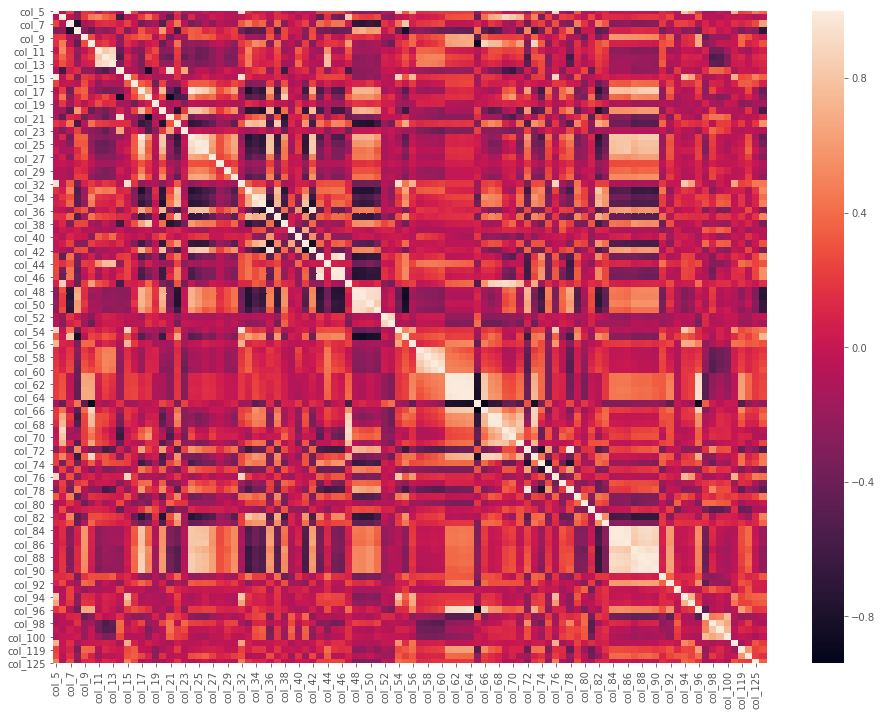

In [32]:
# get Correlation coefficient about all features
corr = df1.corr()
# plot Correlation coefficient
plt.figure(figsize=(16,12))
sns.heatmap(corr)

In [33]:
# get CV s / m
coe_var = df1.std() / df1.mean()
coe_var = coe_var.reset_index().rename(columns = {"index":"columns",0:"cv"}).sort_values("cv",ascending = False)
coe_var

,columns,cv
89,col_95,4.406541
88,col_94,3.485170
48,col_54,2.994685
50,col_56,2.899684
98,col_125,2.554527
...,...,...
41,col_47,0.317011
94,col_100,0.304296
7,col_12,0.290697
59,col_65,0.288732


In [34]:
high_cv = coe_var.iloc[:int(np.sqrt(df1.shape[1] - 1)),0].values
high_cv

array(['col_95', 'col_94', 'col_54', 'col_56', 'col_125', 'col_32',
       'col_5', 'col_15', 'col_76', 'col_118', 'col_10'], dtype=object)

## Exploratory Data Analysis

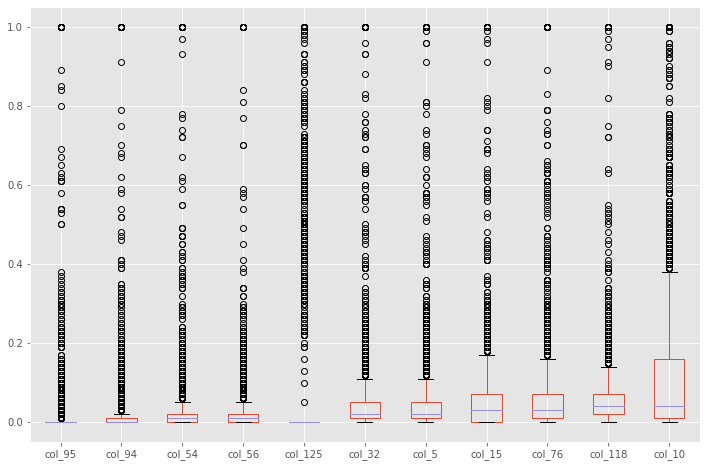

In [35]:
temp = df1[high_cv]
# box plot height cv of features 
plt.figure(figsize=(12,8))
temp.boxplot()

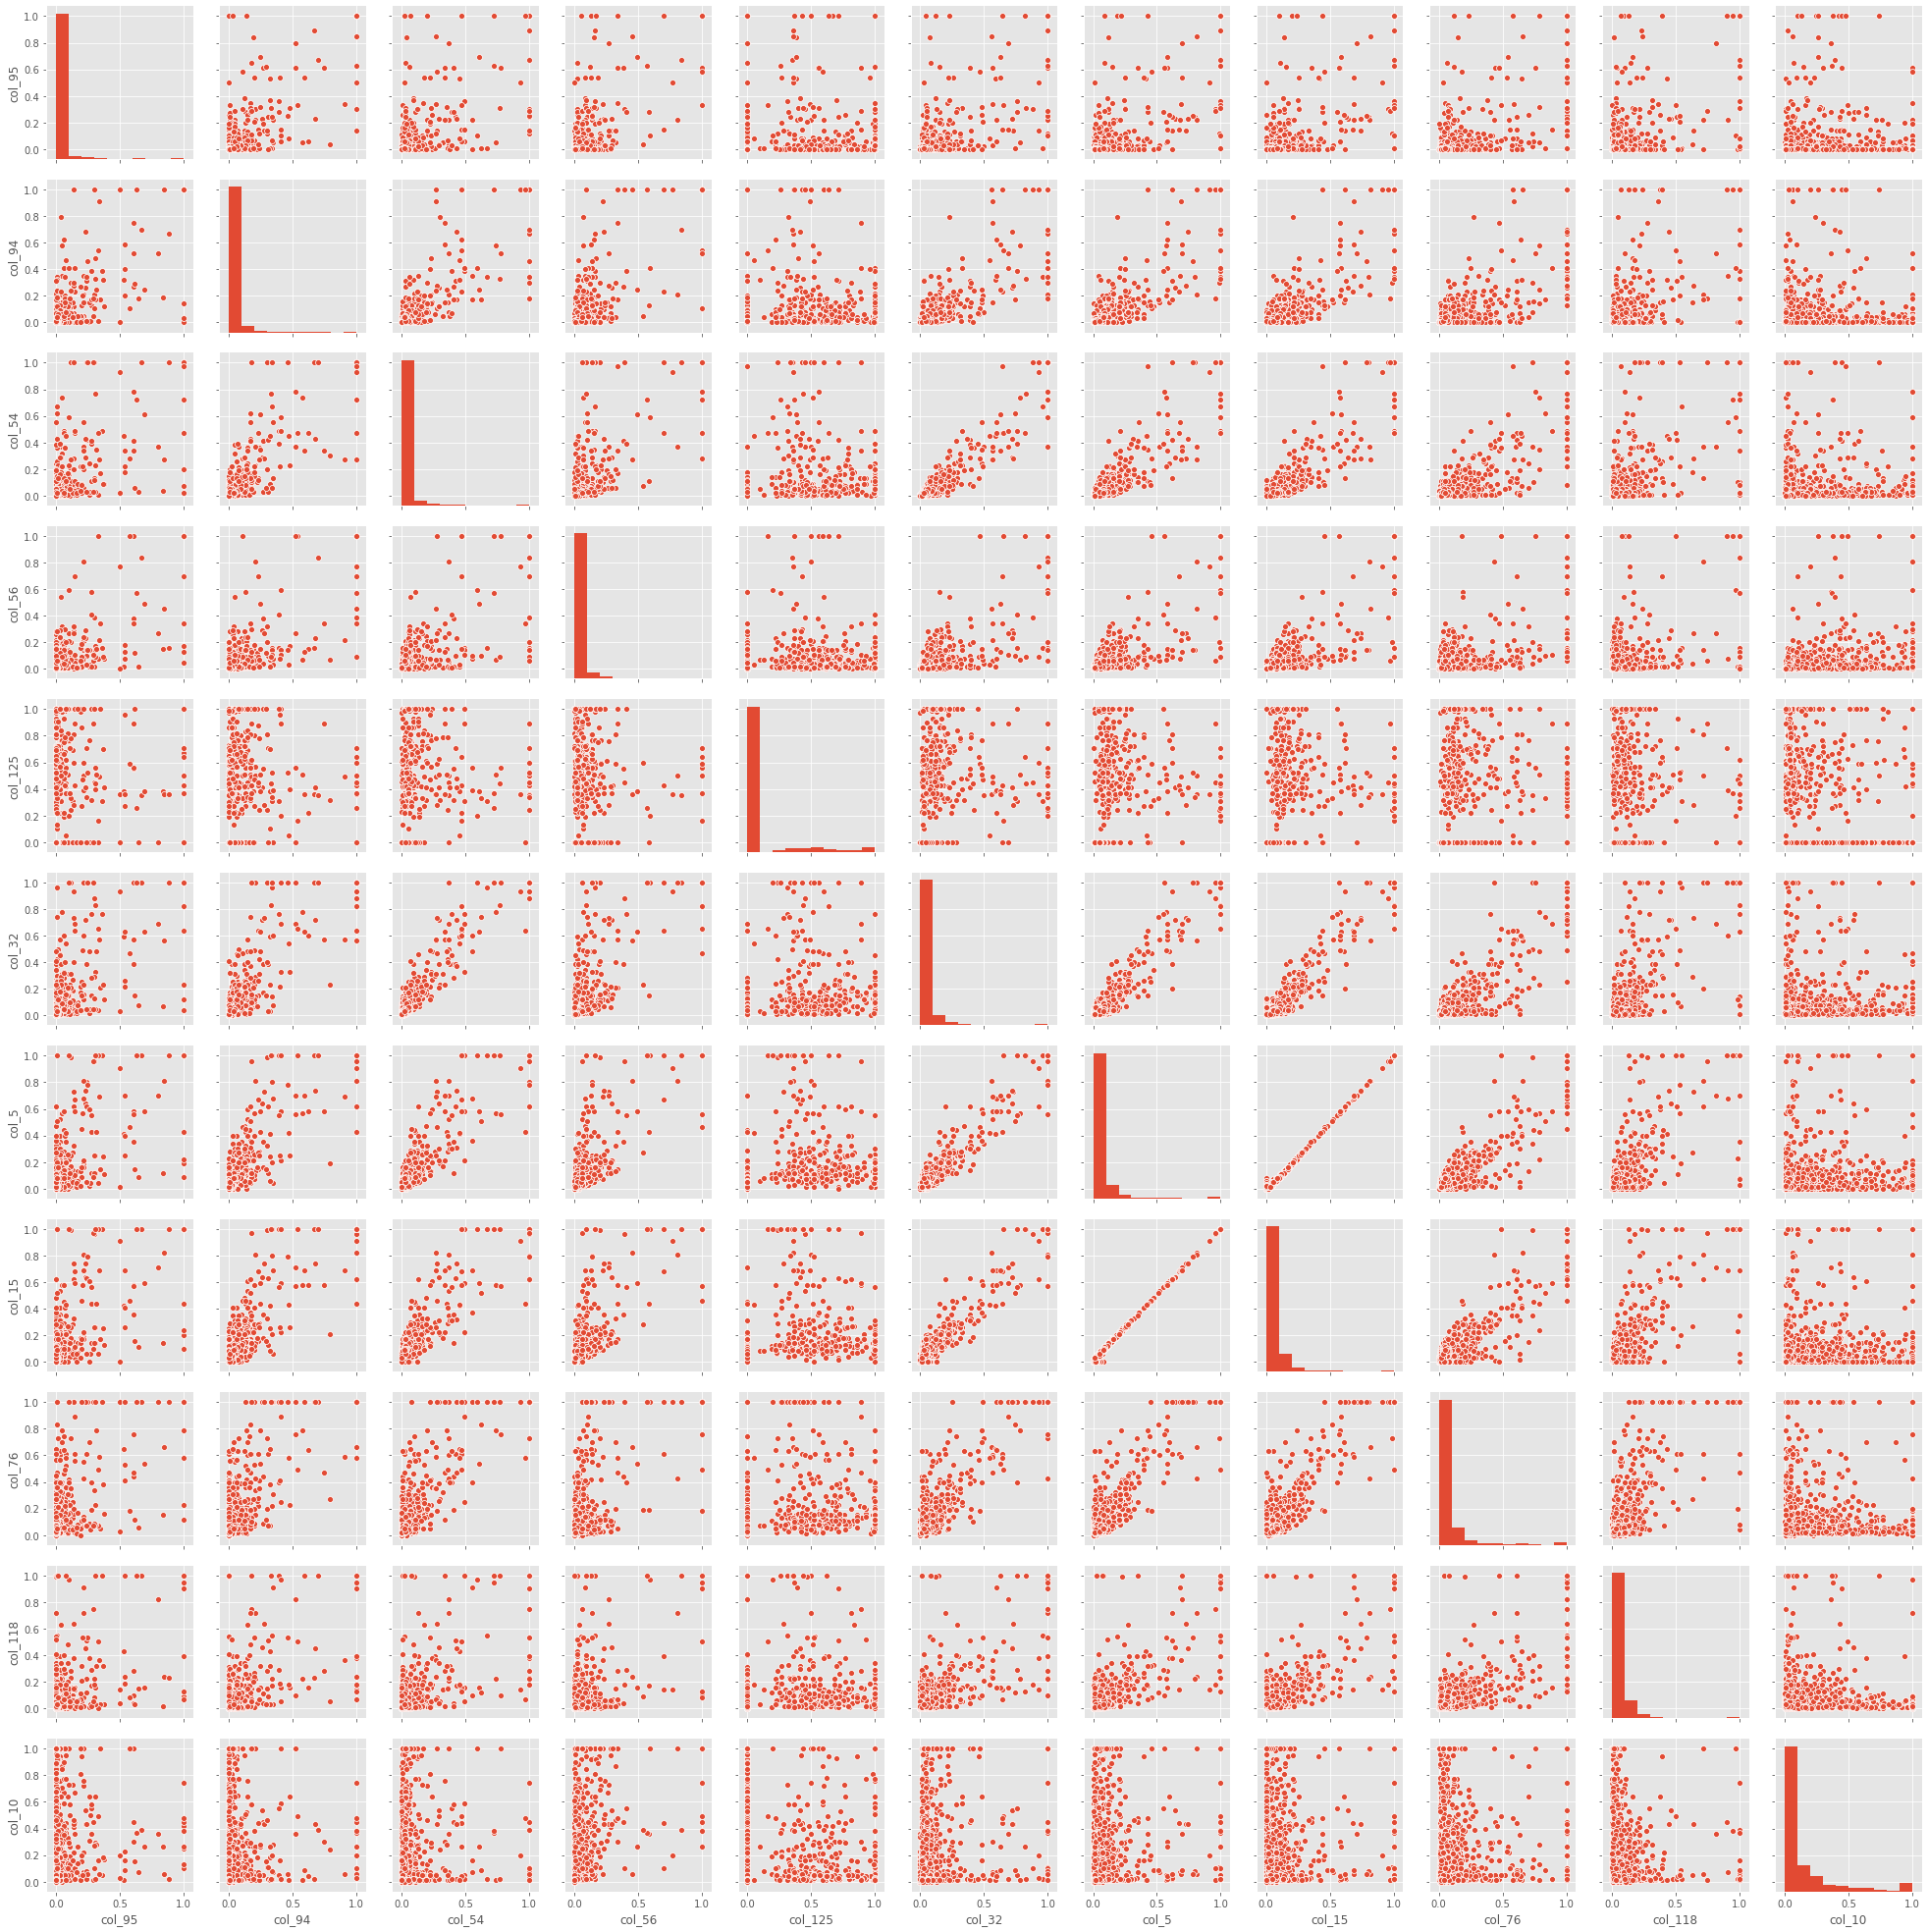

In [36]:
# scatter height cv of features 
sns.pairplot(temp)

## Model Implementation

In [37]:
# split train and test 
train = df1.iloc[:train_size,:]
test = df1.iloc[train_size:,:]
train_y = train.pop('goal')
test_y = test.pop("goal")
train_X = train
test_X = test

### A Linear Regression

In [38]:
# import libraries
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score

# Fit a linear model using least squares to the training set and report the test error.   
lr = LinearRegression(normalize=True)
lr.fit(train_X,train_y)
y_pre = lr.predict(test_X)
# process  abnormal data
y_train = lr.predict(train_X)
y_pre = [0 if i < 0 else i for i in y_pre]
# print train and test error
print("train mse is ",mean_squared_error(train_y,y_train))
print("test mse is ",mean_squared_error(test_y,y_pre))

train mse is  0.016298220397554644
test mse is  6.840110952862753e+17


In [39]:
# use pca model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
# from sklearn.cross_validation import cross_val_score
from sklearn.model_selection import cross_val_predict,cross_val_score,cross_validate
from sklearn.decomposition import PCA

temp = pd.concat([train_X,test_X])
size = train_X.shape[0]

# use pca
pca = PCA(n_components=0.95)
pca.fit(temp)
tt = pca.transform(temp)

train_X = tt[:size,:]
test_X = tt[size:,:]

# Fit a linear model using least squares to the training set and report the test error.   
lr = LinearRegression(normalize=True)
lr.fit(train_X,train_y)
y_pre = lr.predict(test_X)
# process  abnormal data
y_train = lr.predict(train_X)
# print train and test error
print("train mse is ",mean_squared_error(train_y,y_train))
print("test mse is ",mean_squared_error(test_y,y_pre))

train mse is  0.018685223178866346
test mse is  0.018270980851041025


###  Ridge Regularization

In [40]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score


# search for an optimal value of alpha for ridge model
alphas = np.linspace(0.1,10,50)
for k in alphas:
    rd = Ridge(alpha=k)
    # 10 fold cross-validation
    scores = cross_val_score(rd, train_X, train_y, cv=10, scoring='neg_mean_squared_error')
    # print train error
    print("alpha is ",k,"train mse is ",-scores.mean())
# Fit a ridge regression model on the training set, with λ chosen by cross-validation. Report the test error obtained.
ridge = Ridge(alpha=2.726)
ridge.fit(train_X,train_y)
y_pre = ridge.predict(test_X)
# print test error
print("test mse is ",mean_squared_error(test_y,y_pre))

alpha is  0.1 train mse is  0.019831662861588228
alpha is  0.3020408163265306 train mse is  0.019824592950049798
alpha is  0.5040816326530613 train mse is  0.01981780988719257
alpha is  0.7061224489795919 train mse is  0.019811300861917885
alpha is  0.9081632653061225 train mse is  0.01980505380123442
alpha is  1.1102040816326533 train mse is  0.019799057318695468
alpha is  1.3122448979591839 train mse is  0.0197933006670664
alpha is  1.5142857142857145 train mse is  0.01978777369482419
alpha is  1.716326530612245 train mse is  0.019782466806133048
alpha is  1.9183673469387756 train mse is  0.019777370923977355
alpha is  2.1204081632653065 train mse is  0.019772477456166313
alpha is  2.322448979591837 train mse is  0.019767778263953387
alpha is  2.5244897959183676 train mse is  0.019763265633040056
alpha is  2.7265306122448982 train mse is  0.019758932246755748
alpha is  2.928571428571429 train mse is  0.01975477116122676
alpha is  3.1306122448979594 train mse is  0.019750775782364824


### Lasso Regularization

In [41]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
# from sklearn.cross_validation import cross_val_score
from sklearn.model_selection import cross_val_predict,cross_val_score,cross_validate


# search for an optimal value of alpha for Lasso model
alphas = np.linspace(0.1,10,50)
for k in alphas:
    rd = Lasso(alpha=k)
    scores = cross_val_score(rd, train_X, train_y, cv=10, scoring='neg_mean_squared_error')
    print("alpha is ",k,"train mse is ",-scores.mean())
    
# Fit a LASSO model on the training set, with λ chosen by cross-validation. Report the test error obtained, 
# along with a list of the variables selected by the model. 
lass = Lasso(alpha = 0.5)
lass.fit(train_X,train_y)
y_pre = lass.predict(test_X)
print("test mse is ",mean_squared_error(test_y,y_pre))

alpha is  0.1 train mse is  0.04669088033226225
alpha is  0.3020408163265306 train mse is  0.05651041852190025
alpha is  0.5040816326530613 train mse is  0.05651041852190025
alpha is  0.7061224489795919 train mse is  0.05651041852190025
alpha is  0.9081632653061225 train mse is  0.05651041852190025
alpha is  1.1102040816326533 train mse is  0.05651041852190025
alpha is  1.3122448979591839 train mse is  0.05651041852190025
alpha is  1.5142857142857145 train mse is  0.05651041852190025
alpha is  1.716326530612245 train mse is  0.05651041852190025
alpha is  1.9183673469387756 train mse is  0.05651041852190025
alpha is  2.1204081632653065 train mse is  0.05651041852190025
alpha is  2.322448979591837 train mse is  0.05651041852190025
alpha is  2.5244897959183676 train mse is  0.05651041852190025
alpha is  2.7265306122448982 train mse is  0.05651041852190025
alpha is  2.928571428571429 train mse is  0.05651041852190025
alpha is  3.1306122448979594 train mse is  0.05651041852190025
alpha is  

### StandardScaler and Lasso

In [42]:
# import libraries
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

# standar all train_X and test_X data
# Repeat with standardized features. Report the test error for both cases and compare them.
std = StandardScaler()
ss_train = std.fit_transform(train)
ss_test = std.transform(test)

# search for an optimal value of alpha for Lasso model
alphas = np.linspace(0.1,5,50)
for k in alphas:
    rd = Lasso(alpha=k)
    scores = cross_val_score(rd, ss_train, train_y, cv=10, scoring='neg_mean_squared_error')
    print("alpha is ",k,"train mse is ",-scores.mean())
    
lass = Lasso(alpha=0.1)
lass.fit(ss_train,train_y)
y_pre = lass.predict(ss_test)

print("test mse is ",mean_squared_error(test_y,y_pre))


alpha is  0.1 train mse is  0.033937226154489804
alpha is  0.2 train mse is  0.05651041852190025
alpha is  0.30000000000000004 train mse is  0.05651041852190025
alpha is  0.4 train mse is  0.05651041852190025
alpha is  0.5 train mse is  0.05651041852190025
alpha is  0.6 train mse is  0.05651041852190025
alpha is  0.7000000000000001 train mse is  0.05651041852190025
alpha is  0.8 train mse is  0.05651041852190025
alpha is  0.9 train mse is  0.05651041852190025
alpha is  1.0 train mse is  0.05651041852190025
alpha is  1.1 train mse is  0.05651041852190025
alpha is  1.2000000000000002 train mse is  0.05651041852190025
alpha is  1.3000000000000003 train mse is  0.05651041852190025
alpha is  1.4000000000000001 train mse is  0.05651041852190025
alpha is  1.5000000000000002 train mse is  0.05651041852190025
alpha is  1.6 train mse is  0.05651041852190025
alpha is  1.7000000000000002 train mse is  0.05651041852190025
alpha is  1.8000000000000003 train mse is  0.05651041852190025
alpha is  1.90